# Climate Analysis and Exploration

In [1]:
import pandas as pd                                                         
import numpy as np 
import seaborn as sns  
import sqlalchemy
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

In [3]:
sns.set()                                                                    # switch to seaborn default display

In [4]:
trip_start_date = '2018-08-01'                                               # select trip start and end dates
trip_end_date = '2018-08-11'

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")                            # creates SQLite engine

In [6]:
Base = automap_base()                                                        # automap and reflects database
Base.prepare(engine, reflect=True)

In [7]:
conn = engine.connect()                                                      # connect to database
inspector = inspect(engine)                                                  # initializes inspector

In [8]:
Base.classes.keys()                                                          # inspects database

['measurement', 'station']

In [9]:
Measurement = Base.classes.measurement                                       # creates class for each table
Station = Base.classes.station

In [10]:
session = Session(engine)                                                    # initialize session

# Precipitation Analysis

In [11]:
# queries the database for previous years precipitation data.
precip_analysis = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").all()

In [12]:
precip_df = pd.DataFrame(precip_analysis)                                    # load query results => dataframe

In [13]:
# converts date to datetime object - Necessary for proper sorting of plot. See improper sort in README.md.
precip_df['date'] = pd.to_datetime(precip_df['date'])

In [14]:
precip_df = precip_df.set_index('date')                                      # reindex df by date
precip_df.rename(columns = {'prcp': 'precipitation'}, inplace=True)          # rename column for legend
precip_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


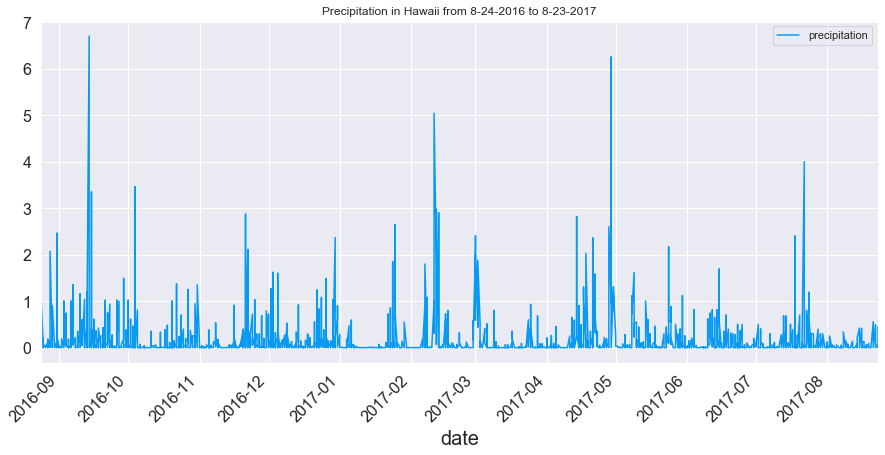

In [15]:
precip_df.plot(figsize=(15, 7),                                              # plot the data
               sort_columns=True, 
               rot=45, 
               use_index=True, 
               title='Precipitation in Hawaii from 8-24-2016 to 8-23-2017', 
               legend=True,
               fontsize=16,
               grid=True,
               color='xkcd:azure'
              )

plt.xlabel('date', fontsize=20)
plt.savefig('./Images/Precipitation.png')
plt.show()

In [16]:
precip_df.describe()                                                         # summary statistic

,precipitation
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Station Analysis

In [17]:
station_count = session.query(Station.id).count()                            # count number of stations
print(f'There are {station_count} weather stations in Hawaii.')

There are 45 weather stations in Hawaii.


In [18]:
# find station activity and sort from most active to least active.
station_activity = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

In [19]:
station_activity                                                             # display station activity

[('USC00519281', 'WAIHEE 837.5, HI US', 69300),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 68100),
 ('USC00513117', 'KANEOHE 838.1, HI US', 67725),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 66725),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 65300),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 55050),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 49475),
 ('USC00517948', 'PEARL CITY, HI US', 34300),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 12775)]

In [20]:
station_activity[0]                                                          # display most active station

('USC00519281', 'WAIHEE 837.5, HI US', 69300)

In [21]:
for row in reversed(station_activity):                                       # extract station with most activity
    most_active_station=row.station
    most_active_name=str(row.name)

In [22]:
# find tobs for most active station
most_active_station_tobs = session.query(Measurement.tobs).\
filter(Measurement.station == most_active_station, Measurement.station == Station.station,\
       Measurement.date >="2016-08-24", Measurement.date <="2017-08-23").all()

In [23]:
temperatures = [temp[0] for temp in most_active_station_tobs]                # extract temperatures from query

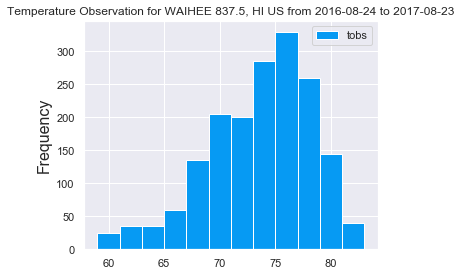

In [24]:
plt.hist(temperatures, bins=12, color='xkcd:azure')                                           # plot the data
plt.title("Temperature Observation for %s from 2016-08-24 to 2017-08-23" % (most_active_name))
plt.ylabel('Frequency', fontsize=16)
labels = ['tobs']
plt.legend(labels)
plt.tight_layout()
plt.savefig('./Images/station-histogram.png')
plt.show()

# Temperature Analysis

In [25]:
# function calc_temps parameters: start (string), end (string)  returns: list
# extracts data using a SQL Alchemy query and returns list of avg temperature, lowest temperature, highest temperature
def calc_temps(start, end):
    temp_list = []
    query = session.query(Measurement.tobs).filter(Measurement.date>=start, Measurement.date<=end).all()
    temperatures = [temp[0] for temp in query]
    temp_list.append(np.mean(temperatures))
    temp_list.append(min(temperatures))
    temp_list.append(max(temperatures))
   
    return temp_list

In [26]:
# function get_prev_year_date parameters: target (string) returns: string
# disassembles string and subtracts 1 from year portion returns parameter input on error
    
def get_prev_year_date(target):
    try:
        xl = target.split('-')
        xc = (str(int(xl[0])-1)) + '-' + xl[1] + '-' + xl[2]
        return xc
    except:
        return target

In [27]:
start_conv = get_prev_year_date(trip_start_date)                             # get previous year start and end dates
end_conv = get_prev_year_date(trip_end_date)

In [28]:
temp_list = calc_temps(start_conv, end_conv)                                 # call calc_temps to get plot data

In [29]:
temp_list                                                                    # display list of plot data

[78.93023255813954, 71, 83]

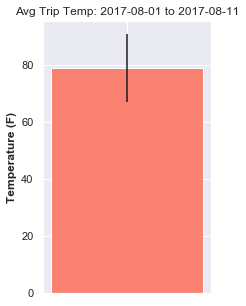

In [30]:
plt.figure(figsize=(3,5))                                                    # plot data
plt.bar(1, temp_list[0], yerr=(temp_list[2] - temp_list[1]), tick_label='', color='salmon')
plt.ylabel("Temperature (F)", weight="bold")
plt.title("Avg Trip Temp: %s to %s" % (start_conv, end_conv))
plt.savefig('./Images/temperature.png')
plt.show()

# Optional Recommended Analysis

In [31]:
# calculates the rainfall per weather station using the previous year's matching dates.

station_rainfall = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp).label('precipitation')).\
filter(Measurement.station == Station.station, Measurement.date >= start_conv, Measurement.date <= end_conv).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

In [32]:
rainfall_df = pd.DataFrame(station_rainfall)                                 # load query result

In [33]:
rainfall_df = rainfall_df.set_index('station')                               # reindexe dataframe by date
del rainfall_df['name']                                                      # delete name column

In [34]:
rainfall_df                                                                  # display dataframe

,precipitation
station,
USC00516128,4.6
USC00514830,1.6
USC00519281,0.3
USC00519397,0.2
USC00519523,0.0


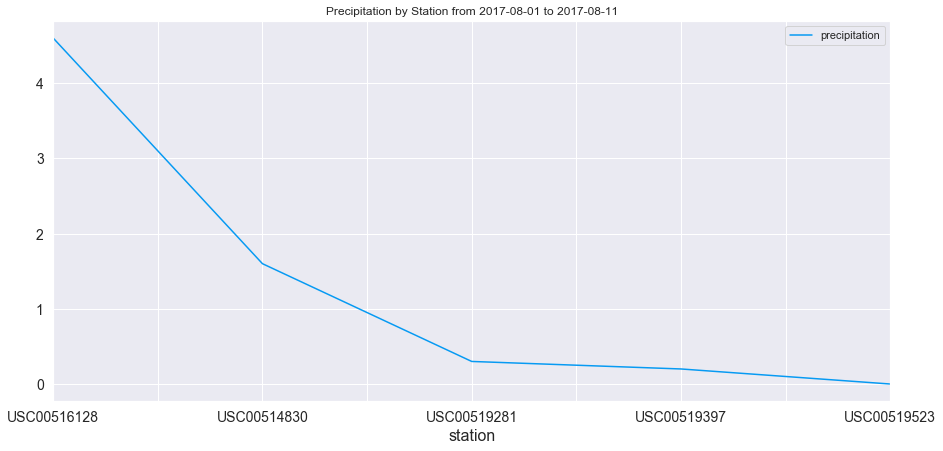

In [35]:
rainfall_df.plot(figsize=(15, 7),                                            # plot the data
               sort_columns=True, 
               use_index=True, 
               title='Precipitation by Station from %s to %s' % (start_conv, end_conv), 
               legend=True,
               fontsize=14,
               grid=True,
               color='xkcd:azure'
              )

plt.xlabel('station', fontsize=16)
plt.savefig('./Images/precip_stats.png')
plt.show()


# Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.

In [36]:
#function get_pdate parameters: target (string) returns: string
# splits input string in date format and returns partial date in %m-%d format.
    
def get_pdate(target):
    target_parse = target.split('-')
    return target_parse[1] + '-' + target_parse[2]

In [37]:
# function daily_normals parameters: target_date (string) returns: list
# extract data using a SQL Alchemy query and returns list of averages of min, avg, and max temperature.
    
def daily_normals(target_date):
    temp_list = []
    query = session.query(Measurement.tobs).filter(Measurement.date.like('%' + get_pdate(target_date))).all()
    temperatures = [temp[0] for temp in query]
    temp_list.append(target_date)
    temp_list.append(min(temperatures))
    temp_list.append(np.mean(temperatures))
    temp_list.append(max(temperatures))
    
    return temp_list

In [38]:
# function get_date_list parameters: start_date (string), end_date (string)  returns: list
# extract all dates between start_date and end_date and returns dates in %Y-%m-%d format.
    
def get_date_list(start_date, end_date):
    date_list = []
    
    tsds = start_date.split('-')
    teds = end_date.split('-')
    
    begin = dt.date(int(tsds[0]), int(tsds[1]), int(tsds[2]))
    end = dt.date(int(teds[0]), int(teds[1]), int(teds[2]))

    next_day = begin
    while True:
        if next_day > end:
            break
        date_list.append(str(next_day))
        next_day += dt.timedelta(days=1)
    
    return date_list

In [39]:
target_date_list = get_date_list(start_conv, end_conv)                       # get target date list

In [40]:
data_list = []                                                               # initialize empty list
for item in target_date_list:
    data_list.append(daily_normals(item))    

In [41]:
# creates dataframe from list data
daily_normals_df = pd.DataFrame(data_list, columns=['date','tmin', 'tavg', 'tmax'])
daily_normals_df = daily_normals_df.set_index('date')                        # reindexe df by date

In [42]:
daily_normals_df                                                             # display df

,tmin,tavg,tmax
date,,,
2017-08-01,67,75.540000,83
2017-08-02,68,75.603774,84
2017-08-03,70,76.611111,85
2017-08-04,69,76.711538,84
2017-08-05,69,76.148148,82
2017-08-06,67,76.250000,83
2017-08-07,71,77.156863,83
2017-08-08,68,76.557692,83
2017-08-09,69,75.980392,81


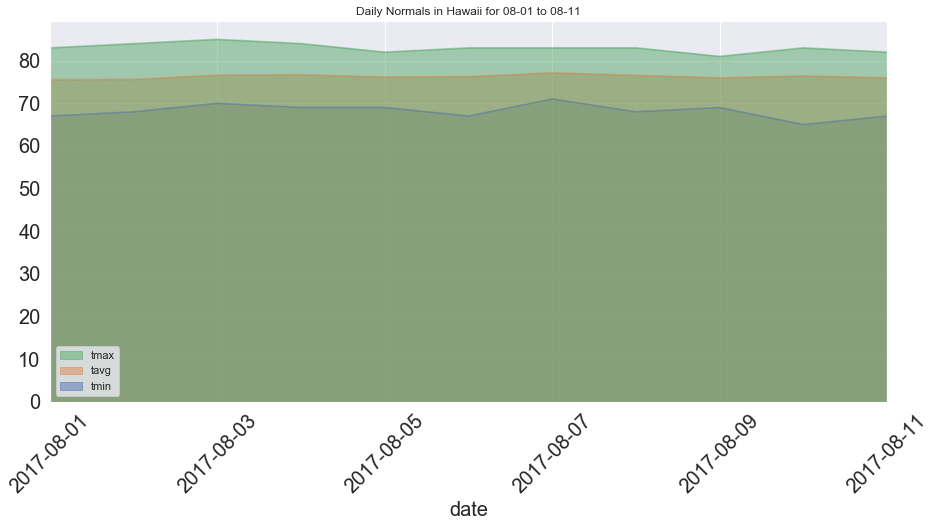

In [43]:
daily_normals_df.plot(figsize=(15, 7),                                       # plot the data
                      kind='area',
                      sort_columns=True, 
                      rot=45, 
                      use_index=True, 
                      title='Daily Normals in Hawaii for %s to %s' % (get_pdate(start_conv), get_pdate(end_conv)), 
                      stacked=False,
                      legend='reverse',
                      fontsize=20,
                      grid=True,
                     ) 

plt.xlabel('date', fontsize=20)
plt.savefig('./Images/daily_normals.png')
plt.show()


# Temperature Analysis  June and December data across all years 

In [44]:
# Reading Hawaii data (tobs)"
tobs_df = pd.read_csv("./Resources/hawaii_measurements_df.csv")
tobs_df.head()

,station,date,prcp,tobs
0,USC00519397,1/1/2010,0.08,65
1,USC00519397,1/2/2010,0.00,63
2,USC00519397,1/3/2010,0.00,74
3,USC00519397,1/4/2010,0.00,76
4,USC00519397,1/6/2010,0.00,73


In [45]:
tobs_df.tail()

,station,date,prcp,tobs
19545,USC00516128,8/19/2017,0.09,71
19546,USC00516128,8/20/2017,0.00,78
19547,USC00516128,8/21/2017,0.56,76
19548,USC00516128,8/22/2017,0.50,76
19549,USC00516128,8/23/2017,0.45,76


In [46]:
tobs_df.date.dtype

dtype('O')

In [47]:
# Change Date format type from string to date & time 
tobs_df.date = pd.to_datetime(tobs_df.date, infer_datetime_format=True)

In [48]:
# Set df index from the date column 
tobs_df = tobs_df.set_index(tobs_df['date'])

In [49]:
# Drop the date column
tobs_df = tobs_df.drop(columns='date')

In [50]:
tobs_df.head()

,station,prcp,tobs
date,,,
2010-01-01,USC00519397,0.08,65
2010-01-02,USC00519397,0.00,63
2010-01-03,USC00519397,0.00,74
2010-01-04,USC00519397,0.00,76
2010-01-06,USC00519397,0.00,73


In [51]:
# Extrat data for June & December months
june_df = tobs_df[tobs_df.index.month == 6]
december_df = tobs_df[tobs_df.index.month == 12]

In [52]:
june_df.mean()

prcp     0.126253
tobs    74.944118
dtype: float64

In [53]:
december_df.mean()

prcp     0.200811
tobs    71.041529
dtype: float64

In [54]:
# Create collections of temperature data
june_temp = june_df.tobs
december_temp = december_df.tobs

In [55]:
# Run  t-test 
stats.ttest_ind(june_temp, december_temp)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)